In [1]:
## which state has the most sightings? over time?
## most frequent shape by state?
## timeline changes? trends?
## sighting density around airports/afb

In [2]:
import os
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [3]:
ufo_df = pd.read_csv('resources/ufo.csv', low_memory=False)
airport_df = pd.read_csv('resources/airports.csv', low_memory=False)

In [4]:
nRow, nCol = ufo_df.shape
print(f'This csv has {nRow} rows and {nCol} columns')

This csv has 70938 rows and 13 columns


In [5]:
#split datetime into date and time and move them to the front of the df

ufo_df[['date', 'time']] = ufo_df.datetime.str.split(' ', expand=True)

first_column = ufo_df.pop('time')
ufo_df.insert(0, 'time', first_column)

first_column = ufo_df.pop('date')
ufo_df.insert(0, 'date', first_column)

ufo_df.pop('datetime')
       
ufo_df.head()

,date,time,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,region,sighting
0,5/8/2014,0:00,memphis,tn,us,rectangle,900,15 minutes,Standing at my window around 0:00 brilliantly ...,5/8/2014,35.149444,-90.048889,Southeast,1
1,5/7/2014,23:30,san isidro,nm,us,unknown,15,15 seconds,2 red lights gliding across sky&#44 then green...,5/8/2014,35.563363,-106.770591,Southwest,2
2,5/7/2014,21:20,hillsboro,mo,us,fireball,360,4-6 minutes,Round slow moving silent ball looked like a ca...,5/8/2014,38.232222,-90.562778,Midwest,3
3,5/7/2014,21:10,naugatuck,ct,us,unknown,300,5 minutes,Large formation of lights in western sky&#44 f...,5/8/2014,41.485833,-73.051111,Northeast,4
4,5/7/2014,21:00,theodore,al,us,circle,120,few minutes,Driving home and entered my neighborhood and s...,5/8/2014,30.547500,-88.175278,Southeast,5


In [6]:
#convert 'duration' column from object to float64

ufo_df.rename(columns = {'duration (seconds)':'duration_sec'}, inplace = True)

ufo_df["duration_sec"] = pd.to_numeric(ufo_df.duration_sec, errors='coerce')

In [7]:
ufo_trim = pd.read_csv('resources/ufo.csv', usecols = ['latitude','longitude','sighting'], low_memory=False)
ufo_trim["latitude"] = ufo_trim["latitude"].astype(np.float32)
ufo_trim["longitude"] = ufo_trim["longitude"].astype(np.float32)
ufo_trim["sighting"] = ufo_trim["sighting"].astype(np.int16)

ufo_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70938 entries, 0 to 70937
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   70938 non-null  float32
 1   longitude  70938 non-null  float32
 2   sighting   70938 non-null  int16  
dtypes: float32(2), int16(1)
memory usage: 692.9 KB


In [8]:
ufo_trim.head()

,latitude,longitude,sighting
0,35.149445,-90.048889,1
1,35.563362,-106.770592,2
2,38.232224,-90.562775,3
3,41.485832,-73.051109,4
4,30.547501,-88.175278,5


In [9]:
airport_trim = pd.read_csv('resources/airports.csv', usecols = ['name','latitude2','longitude2','class'], low_memory=False)
airport_trim["latitude2"] = airport_trim["latitude2"].astype(np.float32)
airport_trim["longitude2"] = airport_trim["longitude2"].astype(np.float32)
airport_trim["name"] = airport_trim["name"].astype(str)
airport_trim["class"] = airport_trim["class"].astype(str)
airport_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        906 non-null    object 
 1   latitude2   906 non-null    float32
 2   longitude2  906 non-null    float32
 3   class       906 non-null    object 
dtypes: float32(2), object(2)
memory usage: 21.4+ KB


In [10]:
airport_trim.head()

,name,latitude2,longitude2,class
0,Yuma International Airport / Marine Corps Air ...,32.656601,-114.606003,Military
1,Sheppard Air Force Base / Wichita Falls Munici...,33.988800,-98.491898,Military
2,Lackland Air Force Base,29.384199,-98.581100,Military
3,Elmendorf Air Force Base,61.251709,-149.807098,Military
4,Wright-Patterson Air Force Base,39.826099,-84.048302,Military


In [11]:
# Renaming the column names 
ufo_trim=ufo_trim.rename(columns = {'latitude':'lat','longitude':'lon'})
airport_trim=airport_trim.rename(columns = {'latitude2':'lat','longitude2':'lon'})
# To make sure that there are no null values and All are either integers/ Float values 
ufo_trim.info() 
print('\n XXXXXXXXXXXXXXXXXXXXXXX\n')
airport_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70938 entries, 0 to 70937
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lat       70938 non-null  float32
 1   lon       70938 non-null  float32
 2   sighting  70938 non-null  int16  
dtypes: float32(2), int16(1)
memory usage: 692.9 KB

 XXXXXXXXXXXXXXXXXXXXXXX

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    906 non-null    object 
 1   lat     906 non-null    float32
 2   lon     906 non-null    float32
 3   class   906 non-null    object 
dtypes: float32(2), object(2)
memory usage: 21.4+ KB


In [12]:
from math import radians, cos, sin, asin, sqrt
def dist(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [13]:
def find_nearest(lat, long):
    distances = airport_trim.apply(
        lambda row: dist(lat, long, row['lat'], row['lon']), 
        axis=1)
    return airport_trim.loc[distances.idxmin(), 'name']

In [14]:
ufo_trim['name'] = ufo_trim.apply(
    lambda row: find_nearest(row['lat'], row['lon']), 
    axis=1)

ufo_trim.head()

,lat,lon,sighting,name
0,35.149445,-90.048889,1,Memphis International Airport
1,35.563362,-106.770592,2,Albuquerque International Sunport
2,38.232224,-90.562775,3,Spirit of St Louis Airport
3,41.485832,-73.051109,4,Tweed New Haven Airport
4,30.547501,-88.175278,5,Mobile Downtown Airport


In [19]:
ufo_trim2 = pd.merge(ufo_trim,airport_trim[['name','lat','lon','class']],on='name', how='left')
# Rename the new columns as both the columns has same name, and python gets confused 

ufo_trim2 = ufo_trim2.rename(columns = {'lat_x':'m_lat','lon_x':'m_lon','lat_y':'h_lat','lon_y':'h_lon'})

ufo_trim2.head()

,m_lat,m_lon,sighting,name,h_lat,h_lon,class
0,35.149445,-90.048889,1,Memphis International Airport,35.042400,-89.976700,Civillian
1,35.563362,-106.770592,2,Albuquerque International Sunport,35.040199,-106.609001,Civillian
2,38.232224,-90.562775,3,Spirit of St Louis Airport,38.662102,-90.652000,Civillian
3,41.485832,-73.051109,4,Tweed New Haven Airport,41.263699,-72.886803,Civillian
4,30.547501,-88.175278,5,Mobile Downtown Airport,30.626801,-88.068100,Civillian


In [21]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

# Creating a new column to generate the output by passing lat long information to Haversine Equation
ufo_trim2['distance'] = [haversine(ufo_trim2.m_lon[i],ufo_trim2.m_lat[i],ufo_trim2.h_lon[i],ufo_trim2.h_lat[i]) for i in range(len(ufo_trim2))]
ufo_trim2['distance'] = ufo_trim2['distance'].round(decimals=3)
# Printing the data table 
ufo_trim2.head(100)

,m_lat,m_lon,sighting,name,h_lat,h_lon,class,distance
0,35.149445,-90.048889,1,Memphis International Airport,35.042400,-89.976700,Civillian,13.595
1,35.563362,-106.770592,2,Albuquerque International Sunport,35.040199,-106.609001,Civillian,59.993
2,38.232224,-90.562775,3,Spirit of St Louis Airport,38.662102,-90.652000,Civillian,48.428
3,41.485832,-73.051109,4,Tweed New Haven Airport,41.263699,-72.886803,Civillian,28.250
4,30.547501,-88.175278,5,Mobile Downtown Airport,30.626801,-88.068100,Civillian,13.528
...,...,...,...,...,...,...,...,...
95,34.915833,-85.109169,96,Chattanooga Metropolitan Airport (Lovell Field),35.035301,-85.203796,Civillian,15.837
96,44.943054,-123.033890,97,Salem Municipal Airport/McNary Field,44.909500,-123.002998,Civillian,4.454
97,34.509724,-88.209167,98,Tupelo Regional Airport,34.268101,-88.769897,Civillian,58.045
98,34.446667,-85.904167,99,Richard B Russell Airport,34.350601,-85.157997,Civillian,69.289


In [50]:
distance_bins = [0, 5, 10, 20, 40, 80, 99999]
distance_ranges = ["<5", "5-9", "10-19", "20-39", "40-79", "80+"]
sighting_total = ufo_trim2['sighting'].count()

ufo_trim2["Distance (km)"] = pd.cut(ufo_trim2["distance"], distance_bins, labels=distance_ranges)
sighting_count = ufo_trim2.groupby(["Distance (km)"]).count()["sighting"].rename("Sightings")
sighting_percent = sighting_count / sighting_total * 100
binned_distance = pd.DataFrame({"Sightings": sighting_count, "Sighting Percent": sighting_percent})

#binned_distance

binned_distance.sort_index().style.format({"Sightings": "{:,.0f}",
                          "Sighting Percent": "{:,.2f}%"})


,Sightings,Sighting Percent
Distance (km),,
<5,"5,660",7.96%
5-9,"15,978",22.47%
10-19,"20,449",28.76%
20-39,"16,860",23.71%
40-79,"10,131",14.25%
80+,"2,020",2.84%


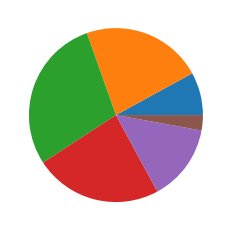

In [30]:
y = binned_distance["Sighting Percent"]

plt.pie(y)
plt.show() 

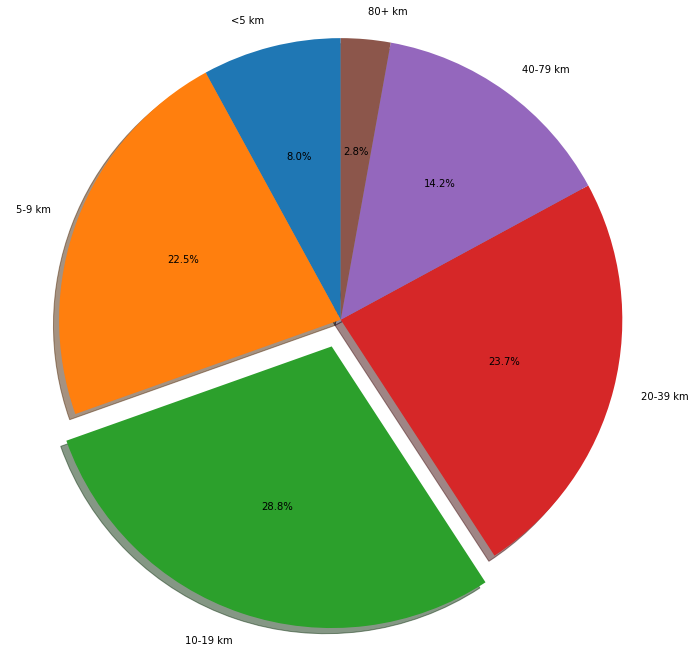

In [35]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = "<5 km", "5-9 km", "10-19 km", "20-39 km", "40-79 km", "80+ km"
sizes = binned_distance["Sighting Percent"]
explode = (0, 0, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

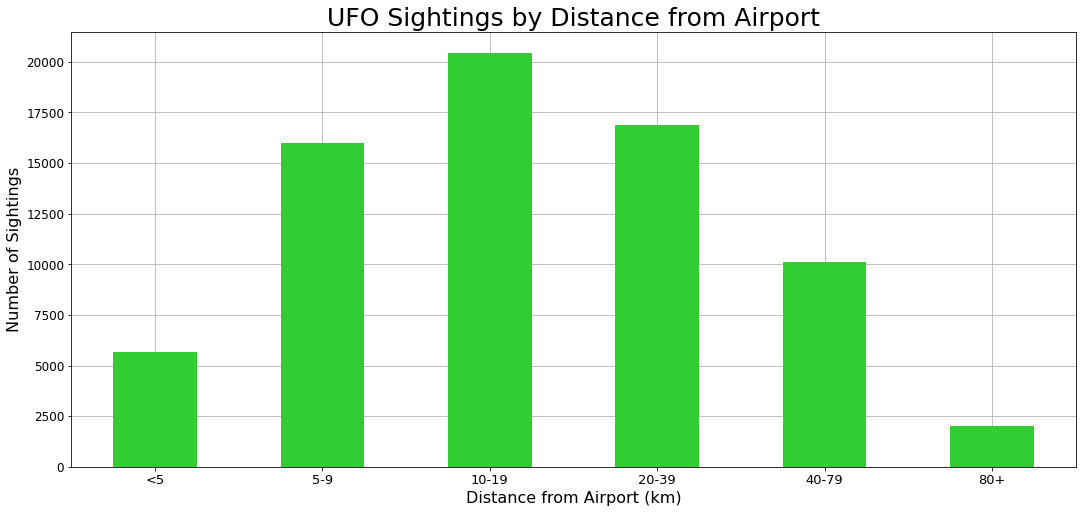

In [44]:
sightings_dist = ufo_trim2['Distance (km)'].value_counts()
sightings_dist = pd.DataFrame(sightings_dist)
sightings_dist = sightings_dist.reset_index()
sightings_dist = sightings_dist.sort_values('index')
sightings_dist = sightings_dist.set_index('index')
sightings_dist.plot(kind='bar',grid=True,zorder=5,color="limegreen",linewidth=10,figsize=(18,8),legend=False)
plt.xticks(size=13, rotation=0)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=16)
plt.xlabel("Distance from Airport (km)", size=16)
plt.title("UFO Sightings by Distance from Airport", size=25)
plt.show()

In [ ]:
class_dist = ufo_trim2.groupby['class','Distance (km)'].value_counts()
class_dist = pd.DataFrame(sightings_dist)
class_dist = class_dist.reset_index()
class_dist = class_dist.sort_values('index')
class_dist = class_dist.set_index('index')
class_dist.plot(kind='bar',grid=True,zorder=5,color="limegreen",linewidth=10,figsize=(18,8),legend=False)
plt.xticks(size=13, rotation=0)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=16)
plt.xlabel("Distance from Airport (km)", size=16)
plt.title("UFO Sightings by Distance from Airport", size=25)
plt.show()